In [1]:
################################
#### Author: Mattijn van Hoek ##
####  While working for HKV   ##
####     Date 2017/06/28      ##
####     Version: 0.1.1       ##
################################

import zeep
from datetime import datetime, timezone, timedelta
import pytz
import pandas as pd
import untangle
import geopandas as gpd
import json
import types
from shapely.geometry import Point
import io
import gzip
import requests
import urllib.parse
import fire
# offset is in seconds
utc_offset = lambda offset: timezone(timedelta(seconds=offset))
try:
    get_ipython().magic('matplotlib inlinde')
except:
    pass

In [2]:
class dataportal(object):
    """
    hkv dataportal to create/update databases, set and get entries.
    """    
    class errors(object):
        """
        error class with different errors to provide for fewsPi
        """        
        def nosetDataservice():     
            raise AttributeError('dataservice not known. set first using hkv.setDataservice()') 

    def setDataservice(self, dataservice, dump=False):
        """
        function to set URL for dataservice to be used in other functions
        
        Parameters
        ----------
        dataservice: str
            URL of dataservice instance (eg. 'http://85.17.82.66/dataservices/')
        """
        setattr(dataportal, 'dataservice', dataservice)
        wsdl = urllib.parse.urljoin(self.dataservice,'data.asmx?WSDL')     
        self.client = zeep.Client(wsdl=wsdl)    
        if dump == False:
            return print(self.dataservice, 'will be used as portal')
        if dump == True:
            return self.client.wsdl.dump()

    def createDatabase(self,database):
        """
        Create database
        
        Parameters
        ----------
        database: str
            name of database instance (eg. 'Myanmar')        
        """
        if not hasattr(self, 'dataservice'):
            self.errors.nosetDataservice()

        url = urllib.parse.urljoin(self.dataservice,'database.asmx/create?database='+database)
        r = requests.get(url)
        return r.json()

    def infoDatabase(self,database):
        """
        Check database info
        
        Parameters
        ----------
        database: str
            name of database instance (eg. 'Myanmar')        
        """
        if not hasattr(self, 'dataservice'):
            self.errors.nosetDataservice()        
        url = urllib.parse.urljoin(self.dataservice,'database.asmx/info?database='+database)
        r = requests.get(url)
        return r.json()

    def setEntryDatabase(self,database,key,data,description=''):
        """
        Set/create/insert new entry in database
        
        Parameters
        ----------
        database: str
            name of database instance (eg. 'Myanmar') 
        key: str
            key to identify datarecord in the database (eg. 'parameter|location|unit')
        data: obj
            object to store in the datarecord (eg. JSON object)
        description: str
            description of the datarecord (default = '')
        """
        if not hasattr(self, 'dataservice'):
            self.errors.nosetDataservice() 
        
        # Set data using create datarecord
        zeep_out = self.client.service.create(database=database, key=key,description=description,data=data)
       
        return json.loads(zeep_out)       

    def getEntryDatabase(self,database, key):
        """
        Get entry after create/insert
        
        Parameters
        ----------
        database: str
            name of database instance (eg. 'Myanmar') 
        key: str
            key to identify datarecord in the database (eg. 'parameter|location|unit')       
        """
        if not hasattr(self, 'dataservice'):
            self.errors.nosetDataservice()        
        url = urllib.parse.urljoin(self.dataservice,'data.asmx/read?database='+database+'&key='+key)
        print (url)
        r = requests.get(url)
        return r.json()

    def deleteEntryDatabase(self,database, key):
        """
        Delete entry from database
        
        Parameters
        ----------
        database: str
            name of database instance (eg. 'Myanmar') 
        key: str
            key to identify datarecord in the database (eg. 'parameter|location|unit')       
        """        
        # delete data from database
        if not hasattr(self, 'dataservice'):
            self.errors.nosetDataservice()        
        url = urllib.parse.urljoin(self.dataservice,'database.asmx/create?database='+database+'&key='+key)
        r = requests.get(url)
        return r.json()
dataportal = dataportal()            

In [60]:
class fewsPi(object):
    
    # create pi object that will be filled with json attributes
    class errors(object):
        """
        error class with different errors to provide for fewsPi
        """
        def nosetClient():
            """
            error to show that the client is unknown
            """
            raise AttributeError('client unknown. did you set it .setClient()?')
            
    class utils(object):
        def event_client_datetime(event, tz_server, tz_client='Europe/Amsterdam'):
            """
            Get datetime object in client time of an XML Element named event with attributes date and time
            input:
            event     : XML Element named event [eg: obj.TimeSeries.series.event[0]]
            tz_server : datetime abbreviation of the server timezone [eg: 'Etc/GMT']
            tz_client : datetime abbreviation of the client timezone [eg: 'Europe/Amsterdam']

            return
            event_client_time : an datetime object of the event in client timezome

            """    
            # convert XML element date string to integer list
            event_server_date = list(map(int, event['date'].split('-'))) # -> [yyyy, MM, dd]
            event_server_time = list(map(int, event['time'].split(':'))) # -> [HH, mm, ss]

            # define server time
            server_time = datetime(event_server_date[0], event_server_date[1], event_server_date[2], 
                                   event_server_time[0], event_server_time[1], event_server_time[2], 
                                   tzinfo=pytz.timezone(tz_server))    
            client_timezone = pytz.timezone(tz_client)

            # returns datetime in the new timezone
            event_client_time = server_time.astimezone(client_timezone)     

            return event_client_time

        def gzip_str(string_):
            """
            write string to gzip compressed bytes object
            """
            out = io.BytesIO()

            with gzip.GzipFile(fileobj=out, mode='w') as fo:
                fo.write(string_.encode())

            bytes_obj = out.getvalue()
            return bytes_obj  
        
        def gunzip_bytes_obj(bytes_obj):
            """
            read string from gzip compressed bytes object
            """            
            in_ = io.BytesIO()
            in_.write(bytes_obj)
            in_.seek(0)
            with gzip.GzipFile(fileobj=in_, mode='rb') as fo:
                gunzipped_bytes_obj = fo.read()

            return gunzipped_bytes_obj.decode()        

    
    def setClient(self, wsdl):
        """
        set soap client using a wsdl URL
        
        Parameters
        ----------
        wsl: str
            provide a URL string to a fewsPi wsdl service 
            (eg. 'http://www.oms-waddenzee.nl:8081/FewsPiService/fewspiservice?wsdl' or
            'http://localhost:8101/FewsPiService?wsdl')       
        """
        self.client = zeep.Client(wsdl=wsdl)

    def getTimeZoneId(self):
        """
        get the servers TimeZoneId 
        
        all the results of get*** functions are also written back in the class object without 'get' 
        (eg result of pi.getTimeZoneId() is stored in pi.TimeZoneId)
        """
        
        if not hasattr(self, 'client'):
            self.errors.nosetClient()
        
        # set new empty attribute in object for filters 
        #fewsPi.getTimeZoneId = types.SimpleNamespace()
                
        getTimeZoneId_response = self.client.service.getTimeZoneId()
        #if not hasattr(self,'getTimeZoneId'):
        setattr(self, 'TimeZoneId', getTimeZoneId_response)
        return self.TimeZoneId
        
    def getFilters(self):
        """
        get the filters known at the pi service, nested filters will be 'unnested'
        
        all the results of get*** functions are also written back in the class object without 'get' 
        (eg result of pi.getTimeZoneId() is stored in pi.TimeZoneId)
        """
        
        if not hasattr(self, 'client'):
            self.errors.nosetClient()
        
        # set new empty attribute in object for filters 
        self.Filters = types.SimpleNamespace()
                
        getFilters_response = self.client.service.getFilters()
        getFilters_json = untangle.parse_raw(getFilters_response)
        #setattr(self.Filters, 'asJSON', getFilters_json)
          
        # iterate over the filters and set in pi object
        for piFilter in getFilters_json.filters.filter:
            if hasattr(piFilter, 'child'):
                for child in piFilter.child:
                    setattr(self.Filters, child['id'].replace(".", "_"), {'id':child['id'],
                                                             'name':child.name.cdata,                                             
                                                             'description':child.description.cdata}) 
    
            setattr(self.Filters, piFilter['id'].replace(".", "_"), {'id':piFilter['id'],
                                                     'name':piFilter.name.cdata,                                             
                                                     'description':piFilter.description.cdata})
        return self.Filters
        
    def getParameters(self, filterId, piVersion='1.22', clientId=''):
        """
        get the parameters known at the pi service given a certain filterId
        
        Parameters
        ----------
        filterId: str
            provide a filterId (if not known, try pi.getFilters() first)
        piVersion: str
            described the version of XML that is returned from the pi service 
            (defaults to 1.22 as current version only can read version 1.22)
        clientId: str
            clientId of the pi service (defaults to '', not sure if it is really necessary)
        
        all the results of get*** functions are also written back in the class object without 'get' 
        (eg result of pi.getTimeZoneId() is stored in pi.TimeZoneId)
        """        
        
        if not hasattr(self, 'client'):
            self.errors.nosetClient()
        
        # set new empty attribute in object for parameters
        self.Parameters = types.SimpleNamespace()

        try:
            # for embedded FewsPi services
            getParameters_response = self.client.service.getParameters(
                in0=clientId,
                in1=filterId,
                in2=piVersion
            )
        except TypeError:
            # for tomcat FewsPi services
            getParameters_response = self.client.service.getParameters(
                clientId=clientId,
                filterId=filterId,
                piVersion=piVersion
            )            
        
        getParameters_json = untangle.parse_raw(getParameters_response)
        
        # iterate over the filters and set in pi object
        for piParameter in getParameters_json.timeseriesparameters.parameter:
            setattr(self.Parameters, piParameter['id'].replace(".", "_"), 
                    {'id':piParameter['id'],
                     'name':piParameter.name.cdata,                                             
                     'parameterType':piParameter.parameterType.cdata,
                     'unit':piParameter.unit.cdata,
                     'displayUnit':piParameter.displayUnit.cdata,
                     'usesDatum':piParameter.usesDatum.cdata})
        return self.Parameters
    
    def getLocations(self, filterId, piVersion='1.22', clientId='', setFormat='geojson'):
        """
        get the locations known at the pi service given a certain filterId
        
        Parameters
        ----------
        filterId: str
            provide a filterId (if not known, try pi.getFilters() first)
        piVersion: str
            described the version of XML that is returned from the pi service 
            (defaults to 1.22 as current version only can read version 1.22)
        clientId: str
            clientId of the pi service (defaults to '', not sure if it is really necessary)
        setFormat: str
            choose the format to return, currently supports 'geojson', 'gdf' en 'dict'
            'geojson' returns GeoJSON formatted output
            'gdf' returns a GeoDataFrame
            'dict' returns a dictionary of locations
        
        all the results of get*** functions are also written back in the class object without 'get' 
        (eg result of pi.getTimeZoneId() is stored in pi.TimeZoneId)
        """ 
        
        if not hasattr(self, 'client'):
            self.errors.nosetClient()
        
        # set new empty attribute in object for locations
        self.Locations = types.SimpleNamespace()

        try:
            # for embedded FewsPi services
            getLocations_response = self.client.service.getLocations(
                in0=clientId,
                in1=filterId,
                in2=piVersion
            )
        except TypeError:
            # for embedded FewsPi services
            getLocations_response = self.client.service.getLocations(
                clientId=clientId,
                filterId=filterId,
                piVersion=piVersion
            )        
        
        getLocations_json = untangle.parse_raw(getLocations_response)
        setattr(self.Locations, 'geoDatum',getLocations_json.Locations.geoDatum.cdata)
        
        # iterate over the filters and set in pi object
        for piLocations in getLocations_json.Locations.location:
            # check if location starts with a digit, if so prepend with an 'L'
            if piLocations['locationId'][:1].isdigit():
                locId = "L{0}".format(piLocations['locationId']).replace(".", "_")
            else:
                locId = piLocations['locationId'].replace(".", "_")
            
            # set attributes of object with location items
            setattr(self.Locations, locId, 
                    {'locationId':piLocations['locationId'],                                            
                     'shortName':piLocations.shortName.cdata,
                     'lat':piLocations.lat.cdata,
                     'lon':piLocations.lon.cdata,
                     'x':piLocations.x.cdata,
                     'y':piLocations.y.cdata                     
                     })
            
        # CREATE dataframe of location rows dictionary
        df = pd.DataFrame(vars(self.Locations)).T
        df = df.loc[df.index != "geoDatum"]
        df[['lon','lat']] = df[['lon','lat']].apply(pd.to_numeric,errors='coerce')

        # CONVERT to geodataframe using latlon for geometry
        geometry = [Point(xy) for xy in zip(df.lon,df.lat)]
        df = df.drop(['lon', 'lat'], axis=1)
        crs = {'init': 'epsg:4326'}
        gdf = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)
        
        setattr(self.Locations, 'asGeoDataFrame',gdf)
        setattr(self.Locations, 'asGeoJSON',gdf.to_json())        
            
        if setFormat == 'geojson':
            return self.Locations.asGeoJSON
        if setFormat == 'gdf':
            return self.Locations.asGeoDataFrame
        if setFormat == 'dict':
            return self.Locations
        
    def getTimeSeries(self, filterId, parameterIds, locationIds, startTime, endTime, convertDatum=True, 
                      useDisplayUnits=False, piVersion='1.22', clientId=None, ensembleId=None,timeZero='', 
                      clientTimeZone='Europe/Amsterdam', setFormat='gzip'):
        """
        get the timeseries known at the pi service given a certain filter, parameter(s), location(s)
        
        Parameters
        ----------
        filterId: str
            provide a filterId (if not known, try pi.getFilters() first)
        parameterIds: str, array of str
            provide the parameter of interest, also (should) accept an array with parameters if multiple are required
        locationIds: str, array of str
            provide the location of interest, also (should) accept an array with locations if multiple are required
        startTime: datetime object
            provide the start time from which you want to extract time series, should be datetime object 
            (eg. datetime(2017,6,1,2, tzinfo=utc_offset(2*60*60)) # offset is in seconds
        endTime: datetime object
            provide the end time from which you want to extract time series, should be datetime object. Currently should
            provide tzinfo as well, otherwise timeZero cannot be computed
            (eg. datetime(2017,6,28,2, tzinfo=utc_offset(2*60*60)) # offset is in seconds
        convertDatum: boolean
            Option to convert values from relative to location height to absolute values (True). If False values remain relative. (default is True)
        useDisplayUnits: boolean
            Option to export values using display units (True) instead of database units (False) (boolean, default is False)            
        piVersion: str
            described the version of XML that is returned from the pi service 
            (defaults to 1.22 as current version only can read version 1.22)
        clientId: str
            clientId of the pi service (defaults to None, not sure if it is really necessary)
        ensembleId: str
            ensembleId (defaults to None)
        timeZero: datetime object
            Forecast time zero. (will default be same as endTime)
        clientTimeZone: str
            set the timezone of the output data, accepts timezones known by pytz module (defaults to 'Europe/Amsterdam')
        setFormat: str
            choose the format to return, currently supports 'geojson', 'gdf' en 'dict'
            'json' returns JSON formatted output
            'df' returns a DataFrame
            'gzip' returns a Gzip compresed JSON string
        
        all the results of get*** functions are also written back in the class object without 'get' 
        (eg result of pi.getTimeZoneId() is stored in pi.TimeZoneId)
        """         
        
        if not hasattr(self, 'client'):
            self.errors.nosetClient()

        # set new empty attribute in object for Timeseries
        self.TimeSeries = types.SimpleNamespace() 
        
        # set TimeZoneId
        self.getTimeZoneId()
            
        # no real idea what to do with timeZero
        timeZero = endTime.astimezone(pytz.utc)
        
        try:
            # for embedded FewsPi services
            getTimeSeries_response = self.client.service.getTimeSeriesForFilter2(
                in0 = clientId,
                in1 = startTime,
                in2 = timeZero,
                in3 = endTime,
                in4 = filterId,
                in5 = locationIds,
                in6 = parameterIds,
                in7 = convertDatum,
                in8 = useDisplayUnits,
                in9 = piVersion
            )
        except TypeError:
            getTimeSeries_response = self.client.service.getTimeSeriesForFilter2(
                clientId = clientId,
                startTime = startTime,
                timeZero = timeZero,
                endTime = endTime,
                filterId = filterId,
                locationIds = locationIds,
                parameterIds = parameterIds,
                convertDatum = convertDatum,
                useDisplayUnits = useDisplayUnits,
                ensembleId = ensembleId,
                piVersion = piVersion
            )            
    
        getTimeSeries_json = untangle.parse_raw(getTimeSeries_response)

        # empty dictionary to fill with dictionary format of each row
        # method adopted to avoid appending to pandas dataframe
        event_attributes = ['value','flag']
        rows_ts_dict = {}
        rows_latlon_list = []

        # start iteration
        for series in getTimeSeries_json.TimeSeries.series:
            # initiate empty lists
            moduleInstanceId = []
            locationId = []

            stationName= []
            parameterId = []
            units = []

            event_datetimes = []
            event_values = []
            event_flags = []

            names = []

            # collect metadata        
            # GET moduleInstanceId
            try:
                moduleInstanceId.append(series.header.moduleInstanceId.cdata)
            except AttributeError as e:
                print ('warning:',e)

            # GET locationId 
            try:
                locationId.append(series.header.locationId.cdata)
            except AttributeError as e:
                print ('warning:',e)

            # GET lat
            try:
                lat = float(series.header.lat.cdata)
            except AttributeError as e:
                print ('warning:',e)        

            # GET lon
            try:
                lon = float(series.header.lon.cdata)
            except AttributeError as e:
                print ('warning:',e)                

            # GET stationNames
            try:
                stationName.append(series.header.stationName.cdata)
            except AttributeError as e:
                print ('warning:',e)          

            # GET parameterId    
            try:
                parameterId.append(series.header.parameterId.cdata)
            except AttributeError as e:
                print ('warning:',e)

            # GET units
            try:
                units.append(series.header.units.cdata)
            except AttributeError as e:
                print ('warning:',e)            

            # GET data values    
            for event in series.event:                    
                event_datetimes.append( self.utils.event_client_datetime(event, tz_server='Etc/'+ self.TimeZoneId, tz_client=clientTimeZone))
                event_values.append( float(event['value']))
                event_flags.append( int(event['flag']))

            # PUT timeseries info into row dictionary
            dataValuesFlags = [event_values,event_flags]
            multiColumns = pd.MultiIndex.from_product([moduleInstanceId, parameterId, units,locationId, stationName, event_attributes], 
                                                      names=['moduleInstanceIds','parameterIds','units','locationIds','stationName','event_attributes'])
            df_ts_dict = pd.DataFrame(dataValuesFlags,index=multiColumns, columns=event_datetimes).T.to_dict()

            # PUT timeseries row in dictionary of rows
            rows_ts_dict.update(df_ts_dict)

        #     # PUT latlon/location info into row dictionary
        #     df_latlon_dict = pd.DataFrame([{'stationName':stationName[0],'lat':lat,'lon':lon}]).to_dict(orient='split')
        #     print (df_latlon_dict)

            # PUT latlon/location row in dictionary of rows
            rows_latlon_list.append({'stationName':stationName[0],'Lat':lat,'Lon':lon})

        # CREATE dataframe of timeseries rows dictionary
        df_timeseries = pd.DataFrame(rows_ts_dict)


        # reset the multiIndex and create a stacked DataFrame and convert to row-oriented JSON object
        df_timeseries = df_timeseries.stack([0,1,2,3,4]).rename_axis(['date','moduleId','parameterId','units','locationId','stationName'])
        
        # prepare settings for database ingestion
        entry = moduleInstanceId[0]+'|'+parameterId[0]+'|'+locationId[0]+'|'+units[0]  

        setattr(self.TimeSeries, 'asDataFrame',df_timeseries)
        setattr(self.TimeSeries, 'asJSON',df_timeseries.reset_index().to_json(orient='records', date_format='iso'))
        setattr(self.TimeSeries, 'asGzip',self.utils.gzip_str(self.TimeSeries.asJSON))
        
        if setFormat == 'json':
            return self.TimeSeries.asJSON, entry
        elif setFormat == 'df':
            return self.TimeSeries.asDataFrame, entry
        elif setFormat == 'gzip':
            #json_timeseries = df_timeseries.reset_index().to_json(orient='records', date_format='iso')
            return self.TimeSeries.asGzip, entry#self.utils.gzip_str(json_timeseries), entry
    
if __name__ == '__main__':
    try:
        # for command line requests
        fire.Fire(fewsPi)
    except:
        # for jupyter notebooks
        pi = fewsPi()

In [61]:
# embedded fewsPi
#url = r'http://localhost:8101/FewsPiService?wsdl'
# tomcat fewsPi
url = r'http://www.oms-waddenzee.nl:8081/FewsPiService/fewspiservice?wsdl'

pi.setClient(wsdl = url)

In [62]:
# return TimeZone Id of FewsPI database
pi.getTimeZoneId()

'GMT'

In [63]:
# get available filters
filters = pi.getFilters()

vars(filters)

{'f_werk': {'description': '',
  'id': 'f_werk',
  'name': 'Uitgevoerde werkzaamheden + peilingen'},
 'f_werk_1': {'description': '',
  'id': 'f_werk.1',
  'name': 'Baggeren + Zandwinning + Agiteren (/baggervak)'},
 'f_werk_2': {'description': '',
  'id': 'f_werk.2',
  'name': 'Verspreiden (/verspreidingsvak)'}}

In [64]:
filterId = pi.Filters.f_werk_1['id']

In [65]:
# get Parameters for specific filter
parameters = pi.getParameters(filterId = filterId)
vars(parameters)#['P_DISDRO_5min']

{'k_m3_geagiteerd_vdlee': {'displayUnit': 'm3',
  'id': 'k.m3.geagiteerd.vdlee',
  'name': 'Kuubs geagiteerd (m3 - dagrapport)',
  'parameterType': 'instantaneous',
  'unit': 'm3',
  'usesDatum': 'true'},
 'k_m3_gebaggerd_mars': {'displayUnit': 'm3',
  'id': 'k.m3.gebaggerd.mars',
  'name': 'Kuubs gebaggerd (m3 - mars)',
  'parameterType': 'instantaneous',
  'unit': 'm3',
  'usesDatum': 'true'},
 'k_m3_gebaggerd_vdlee': {'displayUnit': 'm3',
  'id': 'k.m3.gebaggerd.vdlee',
  'name': 'Kuubs gebaggerd (m3 - dagrapport)',
  'parameterType': 'instantaneous',
  'unit': 'm3',
  'usesDatum': 'true'},
 'k_m3_zandwinning_vdlee': {'displayUnit': 'm3',
  'id': 'k.m3.zandwinning.vdlee',
  'name': 'Kuubs zand winning (m3 - dagrapport)',
  'parameterType': 'instantaneous',
  'unit': 'm3',
  'usesDatum': 'true'}}

In [66]:
parameterId = pi.Parameters.k_m3_gebaggerd_mars['id']

['bv.1.7.1.1', 'bv.1.7.1.1.1.1', 'bv.1.7.1.1.1.2', 'bv.1.7.1.1.1.3', 'bv.1.7.1.1.2.1', 'bv.1.7.1.1.2.2', 'bv.1.7.1.1.2.3', 'bv.1.7.1.1.2.4', 'bv.1.7.1.1.2.5', 'bv.1.7.1.1.2.6', 'bv.1.7.1.2', 'bv.1.7.1.3.1', 'bv.1.7.1.3.1.A', 'bv.1.7.1.3.1.B', 'bv.1.7.1.3.2.1', 'bv.1.7.1.3.2.2', 'bv.1.7.1.3.2.3', 'bv.1.7.1.3.2.4', 'bv.1.7.1.3.2.5', 'bv.1.7.1.3.2.6', 'bv.1.7.1.3.2.7', 'bv.1.7.1.3.2.8', 'bv.1.7.1.4.1.1', 'bv.1.7.1.4.1.2', 'bv.1.7.1.4.1.3', 'bv.1.7.1.4.1.4', 'bv.1.7.1.4.1.5', 'bv.1.7.1.4.2', 'bv.1.7.1.4.A', 'bv.1.7.1.4.B', 'bv.1.7.1.4.C', 'bv.1.7.1.5.1.A', 'bv.1.7.1.5.1.B', 'bv.1.7.1.5.1.C', 'bv.1.7.1.5.1.D', 'bv.1.7.1.5.1.E', 'bv.1.7.1.5.1.F', 'bv.1.7.1.5.1.G', 'bv.1.7.1.5.1.H', 'bv.1.7.1.5.1.I', 'bv.1.7.1.5.1.J', 'bv.1.7.1.5.1.K', 'bv.1.7.1.5.1.L', 'bv.1.7.1.5.1.M', 'bv.1.7.1.5.1.N', 'bv.1.7.1.5.1.O', 'bv.1.7.1.5.2', 'bv.1.7.1.5.3', 'bv.1.7.2.1.1', 'bv.1.7.2.1.1.A', 'bv.1.7.2.1.1.B', 'bv.1.7.2.1.2.1', 'bv.1.7.2.1.2.2', 'bv.1.7.2.2.1', 'bv.1.7.2.2.1.A', 'bv.1.7.2.2.1.B', 'bv.1.7.2.2.2.1',

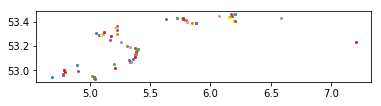

In [67]:
# get Locations for specific filter
gdf = pi.getLocations(filterId = filterId, setFormat='gdf')

# convert to geodataframe and plot points
#gdf = gpd.GeoDataFrame.from_features(json.loads(geojson)['features'])
gdf.geometry.plot()

# get list of locationIds
locationIds = gdf.locationId.tolist()
print (locationIds) 

In [68]:
# test to get locationIds from location object
# get dictornary of first location attribute in object
locationId = pi.Locations.bv_1_7_1_4_1_1['locationId']
#vars(locations)['L13_0002']
# list(vars(locations).keys())

In [69]:
startTime = datetime(2017,6,2,1,0,0,0, tzinfo=utc_offset(0*60*60))
endTime =  datetime(2017,6,11,2,0,0,0, tzinfo=utc_offset(0*60*60))

# with embedded FewsPi can only query a single location. list of locations does NOT work
# in tomcat FewsPi, it is also possible to query list of locations
# for embedded FewsPi its recommended to iterate over all locations (for loop) 
# and ingest into database
# also in embedded FewsPi the startTime endTime does NOT seems to work. The full
# available time series is returned.
# with a tomcat FewsPi this works fine.

timeseries, entry = pi.getTimeSeries(filterId=filterId, parameterIds=parameterId, 
                                     locationIds=locationId, startTime=startTime, endTime=endTime, clientTimeZone='America/Argentina/Buenos_Aires',
                                     setFormat='json', )#, asGzip=True)
print (entry)

pr.Reizen.mars.baggeracties|k.m3.gebaggerd.mars|bv.1.7.1.4.1.1|m3


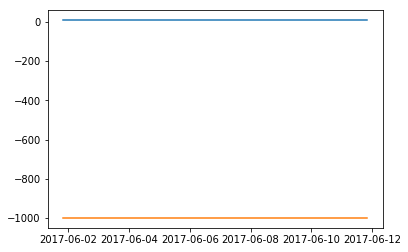

In [70]:
import matplotlib.pyplot as plt
plt.plot(pi.TimeSeries.asDataFrame.index.get_level_values(0), pi.TimeSeries.asDataFrame.values)

In [71]:
pi.TimeSeries.asDataFrame

,,,,,,flag,value
date,moduleId,parameterId,units,locationId,stationName,,
2017-06-01 20:00:00-03:00,pr.Reizen.mars.baggeracties,k.m3.gebaggerd.mars,m3,bv.1.7.1.4.1.1,"Kornwerderzand, Toegangsgeul",8.0,-999.0
2017-06-02 20:00:00-03:00,pr.Reizen.mars.baggeracties,k.m3.gebaggerd.mars,m3,bv.1.7.1.4.1.1,"Kornwerderzand, Toegangsgeul",8.0,-999.0
2017-06-03 20:00:00-03:00,pr.Reizen.mars.baggeracties,k.m3.gebaggerd.mars,m3,bv.1.7.1.4.1.1,"Kornwerderzand, Toegangsgeul",8.0,-999.0
2017-06-04 20:00:00-03:00,pr.Reizen.mars.baggeracties,k.m3.gebaggerd.mars,m3,bv.1.7.1.4.1.1,"Kornwerderzand, Toegangsgeul",8.0,-999.0
2017-06-05 20:00:00-03:00,pr.Reizen.mars.baggeracties,k.m3.gebaggerd.mars,m3,bv.1.7.1.4.1.1,"Kornwerderzand, Toegangsgeul",8.0,-999.0
2017-06-06 20:00:00-03:00,pr.Reizen.mars.baggeracties,k.m3.gebaggerd.mars,m3,bv.1.7.1.4.1.1,"Kornwerderzand, Toegangsgeul",8.0,-999.0
2017-06-07 20:00:00-03:00,pr.Reizen.mars.baggeracties,k.m3.gebaggerd.mars,m3,bv.1.7.1.4.1.1,"Kornwerderzand, Toegangsgeul",8.0,-999.0
2017-06-08 20:00:00-03:00,pr.Reizen.mars.baggeracties,k.m3.gebaggerd.mars,m3,bv.1.7.1.4.1.1,"Kornwerderzand, Toegangsgeul",8.0,-999.0
2017-06-09 20:00:00-03:00,pr.Reizen.mars.baggeracties,k.m3.gebaggerd.mars,m3,bv.1.7.1.4.1.1,"Kornwerderzand, Toegangsgeul",8.0,-999.0


In [ ]:
dataservice = 'http://85.17.82.66/dataservices/'
database = 'Myanmar'

dataportal.setDataservice(dataservice=dataservice,dump=False)

In [ ]:
dataportal.createDatabase(database=database)

In [ ]:
dataportal.infoDatabase(database)

In [ ]:
entry

In [ ]:
dataportal.setEntryDatabase(database=database, key=entry,description='',data=timeseries)

In [ ]:
getData = dataportal.getEntryDatabase(database=database, key=entry)

In [ ]:
getData[0]